# **Python for Finance -- Session 2 -- Assignment**
---
<img src="http://www.doc.ic.ac.uk/~afd/images/logo_imperial_college_london.png" align = "left" width=200>
 <br><br><br><br>
 
- Copyright (c) Antoine Jacquier, 2020. All rights reserved

- Author: Antoine Jacquier <a.jacquier@imperial.ac.uk>

- Platform: Tested on Windows 10 with Python 3.7

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Discrete versus continuous compounding¶

Suppose that you invest $\Pi$ GBP today in a risk-free bank account.
Considering compound interest rate yields the amount if one is earning  is
\begin{equation*}
\Pi\left(1+\frac{r}{n}\right)^{nT}.
\end{equation*}
over the period $[0,T]$, where $r$ is the annual nominal interest rate and $n$ the number of times the interest is compounded per year.
For example, if $n=1$, this is a yearly rate, for $n=2$, this is a 6-month rate, and $n=252$ corresponds to a daily rate.

**Question:** 
- Write a program computing  how much money will be compounded as a function of $\Pi, r, n, T$.
- As $n$ becomes large, compute the limit of Equation (1), and illustrate it numerically.

Available data:
- Annual rates provided by the Bank of England are available here: https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp

- Annual rates by Bank of China can be found here: https://www.global-rates.com/en/interest-rates/central-banks/central-bank-china/pbc-interest-rate.aspx

In [19]:
def discrete_returns (principal, rate, maturity, periods):
    
    return principal * (1. + rate/periods)**(periods*maturity)

In [20]:
def continuous_returns (principal, rate, maturity):
    
    return principal * np.exp(rate * maturity)

In [62]:
P0, r, T = 100, .03, 10.
nn = [2**i for i in range(0, 3)]

data = []

In [63]:
n_max = max(nn)
step = 1./n_max

t_continuous = [t*step for t in range(0, int(T)*n_max + 1)]
r_continuous = [continuous_returns(P0, r, t) for t in t_continuous]

In [64]:
data.append(['continuous', t_continuous, r_continuous])

In [65]:
for n in nn:
    step = 1./n
    i_prev = 0
    t_prev = 0.
    returns_prev = P0
    t_discrete = []
    r_discrete = []
    
    for i in range(1, int(T)*n + 1):
        t = i * step
        returns = discrete_returns(P0, r, t, n)
        
#         print('i = ', i)
#         print('t_prev = ', t_prev)
#         print('returns_prev = ', returns_prev)
#         print('t = ', t)
#         print('returns = ', returns)
#         print()
        
        [t_discrete.extend([t_prev, t, t])]
        [r_discrete.extend([returns_prev, returns_prev, returns])]
        
        t_prev = t
        returns_prev = returns
    
    data.append(['n = %d' %n, t_discrete, r_discrete])

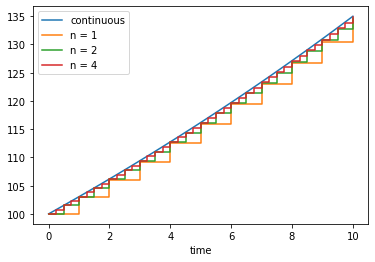

In [66]:
for l in data:
    plt.plot(l[1], l[2], label = l[0])
plt.xlabel("time")
plt.legend(loc = "best")
plt.show()

## Pricing a Call option in Black-Scholes

Write a Python function pricing a Call option in the Black-Scholes model by integration (see Section 5.4 in the notes). Check that, with $(S_0, K, \sigma, t, T) = (100., 100., 0.2, 0., 1.)$,
you obtain a Call option price equal to $7.965567455405798$.

In [77]:
from scipy.stats import norm
from scipy.integrate import quad, simps

import numpy as np

In [78]:
S0, K, r, T, sigma = 100., 100., 0., 1., 0.2

### Reference price (closed-form), see lectures

In [72]:
def BSCall(spotPrice, strikePrice, riskFreeRate, timeToMaturity, volatility):
    
    sigmaT = volatility * np.sqrt(timeToMaturity)
    lnSK = np.log( spotPrice / strikePrice )
    d1 = (lnSK + (riskFreeRate + volatility**2/2.) * timeToMaturity) / sigmaT
    d2 = d1 - sigmaT
    
    return norm.cdf(d1) * spotPrice - norm.cdf(d2) * strikePrice * np.exp(-riskFreeRate * timeToMaturity)

In [83]:
print("Reference Price: ", BSCall(S0, K, r, T, sigma))
print("***************************")

Reference Price:  7.965567455405804
***************************


### Pricing by integration

In [93]:
def integrand(x, spotPrice, strikePrice, riskFreeRate, timeToMaturity, volatility):
    gaussianDensity = np.exp( -0.5*x*x ) / np.sqrt( 2 * np.pi )
    sigmaT = volatility * np.sqrt( timeToMaturity )
    payoffFunction = np.maximum(0.,
                                -strikePrice + spotPrice * np.exp(-0.5*sigmaT**2 + sigmaT*x)
                               )
    
    return payoffFunction * gaussianDensity    

In [94]:
xMin, xMax = -5., +5.
qf = quad(integrand, xMin, xMax, args = (S0, K, r, T, sigma,) )

xx = np.linspace(xMin, xMax, 1000)
qs = simps([integrand(x, S0, K, r, T, sigma) for x in xx], xx)

In [95]:
print("Price by integration: ")
print("Quadrature: ", qf)
print("Simpson: ", qs)
print("***************************")

Price by integration: 
Quadrature:  (7.9655167877012145, 7.187613669845568e-08)
Simpson:  7.965549894118372
***************************


### Pricing by simulation

Using the representation
\begin{equation*}
S_T
 = S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma W_T\right\}
 = S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma\widetilde{n}\sqrt{T}\right\} \text{ (in distribution)},
\end{equation*}
and the approximation
$$
\mathbb{E}[f(S_T)] \approx \frac{1}{N}\sum_{i=1}^{N}f\left(S_T^{(i)}\right),
$$
where $(S_T^{(i)})_{i=1,\ldots,N}$ are independent random copies of $S_T$, write a Python function for a Call option price. With the same parameters as in 2.1, plot the convergence of the Call price as a function of $N$.

**Remark:** Note that here, you do not in fact need to simulate trajectories of the Brownian motion since the option is *European*, i.e. only depends on the value of the underlying stock price at maturity. For path-dependent options, however, simulations of the paths are required.

In [106]:
def BSCallSimulation(n, spotPrice, strikePrice, riskFreeRate, timeToMaturity, volatility):
    nn = np.random.normal(0., 1., (n))
    sigmaT = volatility * np.sqrt( timeToMaturity )
    value = spotPrice * np.exp(-0.5*sigmaT**2 + sigmaT*nn)
    payoff = np.maximum(0., value - strikePrice)
    return np.mean(payoff)

In [112]:
nn = np.arange(500, 100000, 1000)
BSsim = [BSCallSimulation(n, S0, K, r, T, sigma) for n in nn]
BStrue = [BSCall(S0, K, r, T, sigma)]*len(nn)

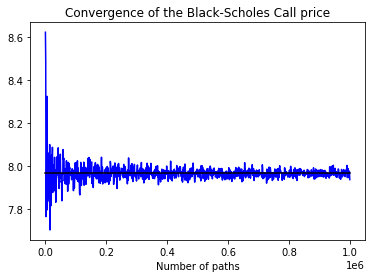

In [113]:
plt.plot(nn, BSsim, 'b')
plt.plot(nn, BStrue, 'k')
plt.title("Convergence of the Black-Scholes Call price")
plt.xlabel("Number of paths")
plt.show()

In [114]:
print("Price by simulation: ")
print("Mean value: ", BSsim[-1])
print("Number of paths: ", nn[-1])
print("***************************")

Price by simulation: 
Mean value:  7.936626995158408
Number of paths:  999500
***************************


## Implied volatility

Recall that in the Black-Scholes model, the value of a European Call option on $(S_t)_{t\geq 0}$ is given at inception by
$$
C^{\mathrm{BS}}(S_0, K, T;\sigma) = S_0\left(\mathcal{N}(d_{+}) - \mathrm{e}^{k}\mathcal{N}(d_{-})\right),
$$
where
$$
d_{\pm} = \frac{-k}{\sigma\sqrt{T}} \pm\frac{\sigma\sqrt{T}}{2}
\quad \text{ and } \quad k := \log\left(\frac{K}{S_0}\right),
$$
and where $\mathcal{N}$ denotes the Gaussian cumulative distribution function.


- For any fixed $k, T, S_0>0$, show that the map $\sigma\mapsto C^{\mathrm{BS}}(S_0, K, T;\sigma)$ is bijective;
- Compute 
\begin{equation*}
\lim_{\sigma\downarrow 0}C^{\mathrm{BS}}(S_0, K, T;\sigma)
\text{  and  }
\lim_{\sigma\uparrow\infty}C^{\mathrm{BS}}(S_0, K, T;\sigma).
\end{equation*}
- Write a Python function with input $S_0, K, T, C$ that returns the implied volatility, solution to the equation $C^{\mathrm{BS}}(S_0, K, T;\sigma) = C$.
*Hint: You can either use a root-finding method using the bijective property, or try to minimise the squared difference*.
- Verify that the implied volatility corresponding to $(S_0, K, T, C) = (100., 100., 1., 7.9655674)$ is equal to $20\%$.

In [115]:
from scipy.optimize import fsolve, root, minimize

In [137]:
def objF(sigma, *args):
    S0, K, r, T, optionPrice = args
    return (BSCall(S0, K, r, T, sigma) - optionPrice)

In [130]:
optionPrice = 7.9656

In [131]:
impliedVol = fsolve(objF, x0 = 0.5, args = ((S0, K, r, T, optionPrice, )))[0]

In [150]:
print("Implied volatility: ", impliedVol)
print("Verification error: ", optionPrice - BSCall(S0, K, r, T, impliedVol))

Implied volatility:  0.2000008198610912
Verification error:  5.329070518200751e-15


In [163]:
solution_root = root(objF, x0 = 0.5, args = ((S0, K, r, T, optionPrice, )))
impliedVol_root = solution_root.x[0]

print(solution_root.message)

The solution converged.


In [152]:
print("Implied volatility (root): ", impliedVol_root)
print("Verification error (root): ", optionPrice - BSCall(S0, K, r, T, impliedVol_root))

Implied volatility (root):  0.2000008198610912
Verification error (root):  5.329070518200751e-15


In [199]:
bnds = ((0, 1), )
solution_min = minimize(objF, x0 = 0.3,
                        bounds = bnds,
                        args = ((S0, K, r, T, optionPrice, )))
impliedVol_min = solution_min.x[0]

print(solution_min.message)

b'ABNORMAL_TERMINATION_IN_LNSRCH'


/Users/gpsmacpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [200]:
## INCORRECT ##
print("Implied volatility (min): ", impliedVol_min)
print("Verification error (min): ", optionPrice - BSCall(S0, K, r, T, impliedVol_min))

Implied volatility (min):  0.3
Verification error (min):  -3.9579384740484986


In [136]:
### ### ###
### END ###
### ### ###